In [1]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as message
from biogeme import expressions as ex
import pandas as pd
import numpy as np
import xlsxwriter

# Calibration
## Estimation of the model parameters
quetzal_germany is being estimated using [PandasBiogeme](https://biogeme.epfl.ch/). This notebook estimates calibration parameters for the model's utility functions.
- Documentation and reference: [Bierlaire, M. (2020). A short introduction to PandasBiogeme. Technical report TRANSP-OR 200605. Transport and Mobility Laboratory, ENAC, EPFL.](https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf)
- Tutorial: https://www.youtube.com/watch?v=OiM94B8WayA

### Model formulation
The model consists of systematic utility functions, one for each mode.

> V_i = ASC + T • b_t_i + C • b_c_i + AC • b_ac_i

Index i marks the demand group. I = {'commuting' (1), 'education' (2), 'shopping/medical' (3), 'business' (4), 'private' (6)}

Note: The cost variable already includes subscriptions

In [2]:
input_path = '../input/'
model_path = '../model/'

### Prepare the database

In [3]:
df = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
df = df[['cost_rail', 'cost_car', 'cost_coach', 'cost_bus', 'cost_walk', 'cost_air',
         'time_rail', 'time_car', 'time_coach', 'time_bus', 'time_walk', 'time_air',
         'accessibility_rail', 'accessibility_car', 'accessibility_coach', 'accessibility_bus',
         'accessibility_walk', 'accessibility_air',
         'mode_model', 'purpose_vp', 'car_avail', 'distance']]
df.columns = ['C_RAIL', 'C_CAR', 'C_COACH', 'C_BUS', 'C_NON_MOTOR', 'C_AIR',
              'T_RAIL', 'T_CAR', 'T_COACH', 'T_BUS', 'T_NON_MOTOR', 'T_AIR',
              'AC_RAIL', 'AC_CAR', 'AC_COACH', 'AC_BUS', 'AC_NON_MOTOR', 'AC_AIR',
              'MODE', 'PURPOSE', 'CAR_AV', 'DIST']

In [4]:
inf = 1e4
df = df.replace({np.inf:inf})

In [5]:
df.describe()

,C_RAIL,C_CAR,C_COACH,C_BUS,C_NON_MOTOR,C_AIR,T_RAIL,T_CAR,T_COACH,T_BUS,...,AC_RAIL,AC_CAR,AC_COACH,AC_BUS,AC_NON_MOTOR,AC_AIR,MODE,PURPOSE,CAR_AV,DIST
count,107870.000000,107870.000000,107870.000000,107870.000000,107870.0,107870.000000,107870.000000,107870.000000,107870.000000,107870.000000,...,107870.000000,107870.000000,107870.000000,107870.000000,107870.0,107870.000000,107870.000000,107870.000000,107870.000000,107870.000000
mean,18.993137,3.125065,3.535950,2.384636,0.0,9577.796384,2886.410473,44.005286,5987.132573,6701.902736,...,0.625315,0.966395,0.625315,0.736479,1.0,0.008484,5.611866,3.652953,0.966562,33.046259
std,179.138402,4.742618,5.882223,0.862219,0.0,1994.178833,4446.719257,51.945427,4827.706628,4671.570884,...,0.289383,0.180212,0.289383,0.310795,0.0,0.064296,1.272668,2.018566,0.183454,54.974047
min,0.000000,0.014477,0.001070,0.000000,0.0,45.000000,1.000000,1.000000,10.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.010000
25%,3.982289,0.943365,1.016500,2.740000,0.0,10000.000000,69.633333,20.000000,168.333333,108.433333,...,0.500000,1.000000,0.500000,0.750000,1.0,0.000000,6.000000,2.000000,1.000000,9.500000
50%,7.518769,1.862069,2.022300,2.740000,0.0,10000.000000,109.733333,30.000000,10000.000000,10000.000000,...,0.750000,1.000000,0.750000,0.900000,1.0,0.000000,6.000000,3.000000,1.000000,18.900000
75%,12.982407,3.521839,3.659400,2.740000,0.0,10000.000000,10000.000000,45.000000,10000.000000,10000.000000,...,0.850000,1.000000,0.850000,0.900000,1.0,0.000000,6.000000,6.000000,1.000000,34.200000
max,10000.000000,106.812632,96.567500,2.740000,0.0,10000.000000,10000.000000,702.900000,10000.000000,10000.000000,...,0.900000,1.000000,0.900000,0.900000,1.0,0.916161,7.000000,6.000000,9.000000,902.500000


In [6]:
# Scale time to hours
df['T_RAIL_S'] = df['T_RAIL'] / 60
df['T_CAR_S'] = df['T_CAR'] / 60
df['T_COACH_S'] = df['T_COACH'] / 60
df['T_BUS_S'] = df['T_BUS'] / 60
df['T_AIR_S'] = df['T_AIR'] / 60
df['T_NON_MOTOR_S'] = df['T_NON_MOTOR'] / 60

In [7]:
# Drop accessibility LoS attribute for cars
df['AC_CAR'] = 0

In [8]:
# Make car availability binary
df['CAR_AV'] = df['CAR_AV'].replace({9:0})

In [9]:
# Remove trips where mode is car but the car availability is zero
# because it irritates the MLE algorithm
mask = ((df['MODE']==6) & (df['CAR_AV']==0))
print('Share of car trips dropped: {}. New number of observations is {}'.format(
    len(df.loc[mask])/len(df.loc[df['MODE']==6]), len(df)))
df = df.loc[~mask]

Share of car trips dropped: 0.012499465834793385. New number of observations is 107870


In [10]:
'''# Create availability column for air transport (drops 50% of air trips)
# All PT modes are accessible by assumption
df['AIR_AV'] = df['AC_AIR'] > 0
df['AIR_AV'] = df['AIR_AV'].astype(int)
# Remove air trips with 0 availability
df = df.loc[~((df['MODE']==5) & (df['AIR_AV']==0))]'''
len(df.index)

106700

In [11]:
# Remove trips where cost are infinity
# Share of drops per mode must be equal, otherwise the calibration is skewed
# Ignore air trips because this dataset has too few observations anyways
max_drop_ratio = 0
lengths = []
for mode, col in zip(range(1,5), ['C_RAIL', 'C_RAIL', 'C_COACH', 'C_BUS']):
    drops = df.loc[((df['MODE']==mode) & (df[col]==inf))].index
    lengths = lengths + list(df.loc[drops, 'DIST'])
    if len(drops) > 0: print('mode ' + str(mode) + ': ' + str(len(drops)) + ' drops')
    max_drop_ratio = max(len(drops) / len(df.loc[df['MODE']==mode]), max_drop_ratio)
print('max_drop_ratio: ' + str(max_drop_ratio))
print('Dropped trips length mean: {}; min: {}; max: {}'.format(
    sum(lengths)/len(lengths), min(lengths), max(lengths)))

mode 2: 34 drops
max_drop_ratio: 0.037694013303769404
Dropped trips length mean: 185.9558823529412; min: 9.0; max: 495.0


In [12]:
# Drop trips with infinite cost
df = df.loc[~((df['MODE']==2) & (df['C_RAIL']==inf))]
# Don't drop coach trips because there are only a few
for m in [1, 4, 6]:
    n_drops = int(max_drop_ratio * len(df.loc[df['MODE']==m]))
    df = df.drop(df.loc[(df['MODE']==m) & (df['DIST']<max(lengths)) &
                        (df['DIST']>min(lengths))].sample(n_drops).index)
    print('mode ' + str(m) + ': ' + str(n_drops) + ' drops')
print('New number of observations: ' + str(len(df.index)))

mode 1: 231 drops
mode 4: 172 drops
mode 6: 3484 drops
New number of observations: 102779


### Model variables
All columns are variables. DefineVariable creates a new column in the database.

#### Cost damping

Many modelling studies have shown that cost damping is required in order to flatten the tail of time/cost elasticities, i.e. decrease the impact of long distances on choice results to prevent from overestimation of time/cost parameters. Cost damping represents the property of decreasing marginal utility. It is commonly approached with Box-Cox transformations of generalised cost (usually defined as the sum of travel time and travel expenditures divided by the value of time). Daly (2010) proposes a hybrid function as a sum of the linear term and the narural logarithm of the same. However, the linear term still dominates cost on long distances. Rich (2015), main developer of the Danish National Transport Model, proposes a more complex spline function which successfully manages cost damping and even outperforms the Box-Cox transformation in terms of stability of elasticities.

In [13]:
# Using the hybrid linear-logarithmic version requires a new column
# for the logarithm of time in minutes
'''df['T_RAIL_S'] = np.log(df['T_RAIL'])
df['T_CAR_S'] = np.log(df['T_CAR'])
df['T_COACH_S'] = np.log(df['T_COACH'])
df['T_BUS_S'] = np.log(df['T_BUS'])
df['T_AIR_S'] = np.log(df['T_AIR'])
df['T_NON_MOTOR_S'] = np.log(df['T_NON_MOTOR'])'''
print('This functional form performes poorly')

This functional form performes poorly


#### Generalised cost

Both, travel time and monetary cost should be affected by cost damping measures. It is logical to define a generalised cost term `GC` with dimension of time units. This requires definition or estimation of values of time, in order to rescale monetary units, for all segments. Usually, the value of time (VoT) is distance-dependent. In the case of Germany, VoT can be taken from research undertaken within the Federal Government's transport study "Bundesverkehrswegeplan 2030": Axhausen et al. 2015. Ermittlung von Bewertungsansätzen für Reisezeiten und Zuverlässigkeit auf der Basis eines Modells für modale Verlagerungen im nicht-gewerblichen und gewerblichen Personenverkehr für die Bundesverkehrswegeplanung

In [14]:
# VoT from literature, distance-dependent, see cal19
VoT = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0)
VoT.sample(2)

,root,Fz1,Fz2,Fz3,Fz4,Fz6,root,Fz1,Fz2,Fz3,...,Fz2,Fz3,Fz4,Fz6,root,Fz1,Fz2,Fz3,Fz4,Fz6
,all,all,all,all,all,all,PT,PT,PT,PT,...,air,air,air,air,car,car,car,car,car,car
274,15.3320,14.7528,9.18,11.9,17.1760,12.0164,11.7056,9.3236,13.48,13.7588,...,28.3612,28.3612,29.5588,19.0344,15.2724,14.6032,9.4784,19.6548,16.3564,12.0164
111,12.2216,11.8240,9.18,11.9,13.3748,9.9648,9.4624,7.8064,13.48,12.2664,...,19.1600,19.1600,24.4700,15.8300,12.2628,11.8152,7.8952,16.0356,13.2840,9.9648


In [15]:
# Make distance integer
df['DIST'] = df['DIST'].apply(int)

In [16]:
# Generate generalised cost
VoT = VoT.to_dict()
df['GC_RAIL'] = df['T_RAIL_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                  for c,d,p in zip(df['C_RAIL'], df['DIST'], df['PURPOSE'])]
df['GC_COACH'] = df['T_COACH_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                    for c,d,p in zip(df['C_COACH'], df['DIST'], df['PURPOSE'])]
df['GC_BUS'] = df['T_BUS_S'] + [c / VoT[('Fz'+str(p), 'PT')][d]
                                for c,d,p in zip(df['C_BUS'], df['DIST'], df['PURPOSE'])]
df['GC_AIR'] = df['T_AIR_S'] + [c / VoT[('Fz'+str(p), 'air')][d]
                                for c,d,p in zip(df['C_AIR'], df['DIST'], df['PURPOSE'])]
df['GC_CAR'] = df['T_CAR_S'] + [c / VoT[('Fz'+str(p), 'car')][d]
                                for c,d,p in zip(df['C_CAR'], df['DIST'], df['PURPOSE'])]
df['GC_NON_MOTOR'] = df['T_NON_MOTOR_S']

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

<AxesSubplot:xlabel='DIST'>

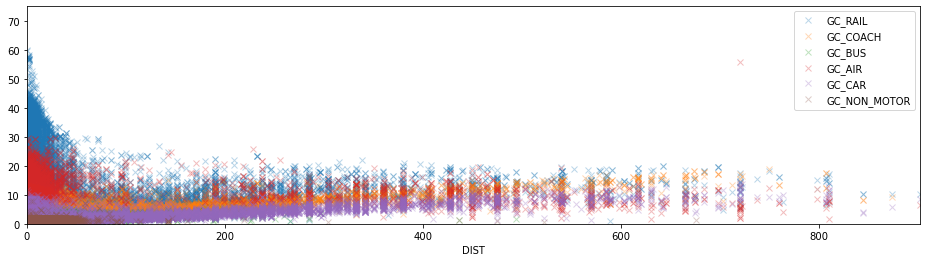

In [17]:
df.set_index('DIST')[[col for col in df.columns if col.startswith('GC_') and col[-1]!='D']].plot(
    figsize=(16,4), linestyle=' ', marker='x', alpha=.3, ylim=(0, 75))

In [18]:
# Create the initial database and make columns global variables
database = db.Database('MiD2017', df.copy())
globals().update(database.variables)
database.getSampleSize()

102779

### Estimation parameters

In [19]:
asc_rail = ex.Beta('asc_rail', 0, None, None, 0)
asc_coach = ex.Beta('asc_coach', 0, None, None, 0)
asc_bus = ex.Beta('asc_bus', 0, None, None, 0)
asc_air = ex.Beta('asc_air', 0, None, None, 0)
asc_car = ex.Beta('asc_car', 0, None, None, 1)
asc_non_motor = ex.Beta('asc_non_motor', 0, None, None, 0)

In [20]:
b_t = ex.Beta('b_t', 0, None, None, 0)
b_c = ex.Beta('b_c', 0, None, None, 0)
b_ac = ex.Beta('b_ac', 0, None, None, 0)

In [21]:
# non-linear time component
b_t2 = ex.Beta('b_t2', 0, None, None, 0)

In [22]:
# generalised cost function parameter
b_gc = ex.Beta('b_gc', 0, None, None, 0)

In [23]:
# Parameters for the nested logit structure
mu_pt = ex.Beta('mu_pt', 1, 1, 10, 0)

### Utility functions

In [24]:
# Aggregated formulation
V_RAIL = asc_rail + b_t * T_RAIL_S + b_c * C_RAIL + b_ac * AC_RAIL
V_COACH = asc_coach + b_t * T_COACH_S + b_c * C_COACH + b_ac * AC_COACH
V_BUS = asc_bus + b_t * T_BUS_S + b_c * C_BUS + b_ac * AC_BUS
V_AIR = asc_air + b_t * T_AIR_S + b_c * C_AIR + b_ac * AC_AIR
V_CAR = asc_car + b_t * T_CAR_S + b_c * C_CAR
V_NON_MOTOR = asc_non_motor + b_t * T_NON_MOTOR_S

In [25]:
# Aggregated formulation with non-linear perception of travel time
V_RAIL = asc_rail + b_t * T_RAIL + b_t2 * T_RAIL_S + b_c * C_RAIL + b_ac * AC_RAIL
V_COACH = asc_coach + b_t * T_COACH + b_t2 * T_COACH_S + b_c * C_COACH + b_ac * AC_COACH
V_BUS = asc_bus + b_t * T_BUS + b_t2 * T_BUS_S + b_c * C_BUS + b_ac * AC_BUS
V_AIR = asc_air + b_t * T_AIR + b_t2 * T_AIR_S + b_c * C_AIR + b_ac * AC_AIR
V_CAR = asc_car + b_t * T_CAR + b_t2 * T_CAR_S + b_c * C_CAR
V_NON_MOTOR = asc_non_motor + b_t * T_NON_MOTOR + b_t2 * T_NON_MOTOR_S

In [26]:
# The cost damping function
def spline(x, beta=b_gc, Q=3, c0=0, c1=20, c2=40, c3=np.inf):
    alpha = [0, -beta/2*ex.Power(ex.log(c1),3),
             -beta/2*ex.log(c1)*(3*ex.Power(ex.log(c2),2)+ex.Power(ex.log(c1),2))] # for Q=3
    theta = [1, 3/2*ex.log(c1), 3*ex.log(c1)*ex.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*ex.Power(ex.log(x),Q-q+1) + alpha[q-1]
    if x < c1:
        return component(x,1)
    elif x < c2:
        return component(x,2)
    elif x >= c2:
        return component(x,3)
    #return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])

In [27]:
# Aggregated formulation with damped generalised cost
V_RAIL = asc_rail + spline(GC_RAIL) + b_ac * AC_RAIL
V_COACH = asc_coach + spline(GC_COACH) + b_ac * AC_COACH
V_BUS = asc_bus + spline(GC_BUS) + b_ac * AC_BUS
V_AIR = asc_air + spline(GC_AIR) + b_ac * AC_AIR
V_CAR = asc_car + spline(GC_CAR)
V_NON_MOTOR = asc_non_motor + spline(GC_NON_MOTOR)

### Run the estimation

In [28]:
# Define level of verbosity
logger = message.bioMessage()
#logger.setSilent()
logger.setWarning()
#logger.setGeneral()
#logger.setDetailed()

In [29]:
# Map modes to utility functions
V = {1:V_RAIL,
     2:V_RAIL,
     3:V_COACH,
     4:V_BUS,
     5:V_AIR,
     6:V_CAR,
     7:V_NON_MOTOR}

In [30]:
# Map the availability of alternatives with MODE as key
# PT is always available
av = {1:1,
      2:1,
      3:1,
      4:1,
      5:1,
      6:CAR_AV,
      7:1}

In [31]:
# Mode nests as tuples with nest name and dictionary where
# alternative IDs are mapped to alpha values. Missing ID's alpha is zero
# Alternatively use lists with mode ID without alpha
nests = ((mu_pt, [1, 2, 3, 4]), # PT
         (1, [5]), # Air is seperated
         (1, [6]), # Car
         (1, [7])) # Non-motorised

In [32]:
# Choose the multinomial logit model
mnl = models.loglogit(V, av, MODE)

In [33]:
model_mnl = bio.BIOGEME(database, mnl)
model_mnl.modelName = 'MNL'

In [34]:
results_mnl = model_mnl.estimate()

In [35]:
results = results_mnl.getEstimatedParameters()
for key, val in results_mnl.getGeneralStatistics().items():
    results.loc[key] = [val[0], val[1]] + ['' for i in range(len(results.columns)-2)]
results

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
asc_air,-5.079053,0.273729,-18.555,0,0.446023,-11.3874,0
asc_bus,-2.153090,0.0367787,-58.5418,0,0.0428986,-50.1902,0
asc_coach,-8.649331,0.352296,-24.5513,0,1.94978,-4.43606,9.16184e-06
asc_non_motor,-2.754671,0.0250694,-109.882,0,0.0272696,-101.016,0
asc_rail,-1.854882,0.0329167,-56.3508,0,0.040955,-45.2907,0
b_ac,0.489329,0.042536,11.5039,0,0.0500881,9.76938,0
b_gc,-0.334919,0.00540607,-61.9524,0,0.0149072,-22.4669,0
Number of estimated parameters,7.000000,,,,,,
Sample size,102779.000000,,,,,,
Excluded observations,0.000000,,,,,,


In [36]:
# Write results to a file
writer = pd.ExcelWriter(input_path + 'estimation_results_splineGC_distVoT_knots2040_2.xlsx', engine='xlsxwriter')

In [37]:
results.to_excel(writer, sheet_name=model_mnl.modelName)

In [38]:
# Choose the logarithmic nested logit model
nl = models.lognested(V, av, nests, MODE)

In [39]:
# Nested Logit
model_nl = bio.BIOGEME(database, nl)
model_nl.modelName = 'NL'

In [40]:
results_nl = model_nl.estimate()

In [41]:
results = results_nl.getEstimatedParameters()
for key, val in results_nl.getGeneralStatistics().items():
    results.loc[key] = [val[0], val[1]] + ['' for i in range(len(results.columns)-2)]
results

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
asc_air,-5.242584,0.265559,-19.7417,0,0.437406,-11.9856,0
asc_bus,-2.115940,0.0349072,-60.6162,0,0.0397318,-53.2556,0
asc_coach,-4.692038,0.07045,-66.6009,0,0.102362,-45.8377,0
asc_non_motor,-2.920181,0.0270105,-108.113,0,0.0352655,-82.8055,0
asc_rail,-2.448750,0.0325652,-75.1953,0,0.0358534,-68.299,0
b_ac,0.534639,0.040593,13.1707,0,0.0465987,11.4733,0
b_gc,-0.375476,0.00640299,-58.6407,0,0.0205418,-18.2787,0
mu_pt,1.472993,0.0295052,49.9231,0,0.0519817,28.3368,0
Number of estimated parameters,8.000000,,,,,,
Sample size,102779.000000,,,,,,


In [42]:
results.to_excel(writer, sheet_name=model_nl.modelName)

In [43]:
# Run the estimation by purpose
results = []
for p in [1,2,3,4,6]:
    database = db.Database('MiD2017', df.copy())
    database.remove(PURPOSE!=p)
    print('Sample size for purpose {}: {}'.format(p, database.getSampleSize()))
    model = bio.BIOGEME(database, nl) # Choose the model formulation
    model.modelName = 'NL_Fz' + str(p) # Name it
    results.append(model.estimate()) # Estimation
    output = results[-1].getEstimatedParameters()
    # Add results to the Excel file
    for key, val in results[-1].getGeneralStatistics().items():
        output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
    output.to_excel(writer, sheet_name=model.modelName)

Sample size for purpose 1: 25456
Sample size for purpose 2: 4448
Sample size for purpose 3: 28751
Sample size for purpose 4: 5295
Sample size for purpose 6: 38829


In [44]:
writer.save()

In [44]:
# Generate LaTeX code
file = open(input_path + 'estimation_results_LaTeX_code.txt', 'w')
for r in results:
    file.write(r.getLaTeX())
file.close()